# Setup

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

In [5]:
data = np.array([-2.10156743, -1.8583213 , -2.11703494, -2.06448116, -2.01051116,
       -1.99979037, -2.00745361, -1.91303719, -1.71658038, -2.03513678,
       -1.8671988 , -1.98053945, -2.05135859, -2.05002873, -2.03048385,
       -1.85493751, -1.99955027, -2.00088738, -1.93089063, -1.93584365,
        1.93655427,  2.02697566,  1.89414285,  1.94652809,  2.04512789,
        1.92124268,  1.98938654,  1.96876467,  1.93261298,  2.07054605,
        2.18631844,  2.06854217,  1.75776435,  1.96133907,  2.04214097,
        1.93294967,  2.06293103,  1.90393445,  2.04024823,  2.09286621])

# Define the model

In [6]:
def g0_sampler():
    return np.random.normal(0, 1)

def f_sampler(theta):
    return np.random.normal(theta, 0.1)

def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / (2 * 0.1**2))

In [7]:
def DP_sampler(n, alpha):
    # Sample the phis
    thetas = []
    for i in range(n):
        u = np.random.uniform()
        if u < alpha / (alpha + i):
            thetas.append(g0_sampler())
        else:
            thetas.append(thetas[np.random.randint(0, i)])
    return thetas

In [8]:
tau = 0.2

def Hi_sampler(y):
    m = (y / tau**2) / (1 / tau**2 + 1 / 1**2)
    s = 1 / (1 / tau**2 + 1 / 1**2)
    return np.random.normal(m, s)

def ri_integral(y):
    return tau * np.exp(-y**2 / (2 + 2 * tau**2)) / np.sqrt(tau**2 + 1)

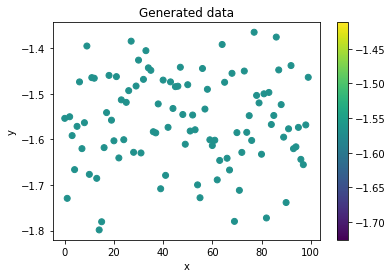

In [9]:
# Generate data
n = 100
alpha = 0.3
thetas = DP_sampler(n, alpha)
y = np.array([f_sampler(theta) for theta in thetas])

# Plot data
plt.figure()
plt.scatter(np.arange(n), y, c=thetas)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

In [10]:

def find_unused_cluster(c):
    # Find the first unused cluster
    for k in range(len(c)):
        if np.sum(c == k) == 0:
            return k

    raise Exception("No unused cluster found")

# Algorithm 5

In [14]:
def algorithm_5_sampler(alpha, c_unique, c_count, c, n):
        # Draw a candidate phi_i_star from Eq 5.4
        new_parameter_prob = alpha / (n - 1 + alpha)
        old_parameter_prob = 1 / (n - 1 + alpha)
        # Sampling probabilities for all [old params , new param] and normalize to get a probability distribution
        sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
        sampling_prob /= np.sum(sampling_prob)
        # Choose cluster with probability sampling_prob
        # The new cluster replaces an unused cluster
        ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
        return ci_star


In [15]:
def algorithm_5(n_iters, y, alpha):
    n = len(y)
    cs = np.zeros((n_iters+1, n), dtype=int)
    phis = np.zeros((n_iters+1, n), dtype=float)
    lhs = np.zeros((n_iters+1, n), dtype=float)

    for iter in range(1,n_iters+1):
        c = cs[iter-1].copy()
        phi = phis[iter-1].copy()
        lh = lhs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)
            # Sample a ci_star from Eq 5.4
            ci_star = algorithm_5_sampler(alpha, c_unique, c_count, c, n)

            # If the sampled index is the last one, we sample from G0
            if ci_star == len(c_unique):
                phi_proposal = g0_sampler()
            else: # Else we use an existing cluster
                phi_proposal = phi[ci_star]
            
            lh_proposal = F_likelihood(phi_proposal, y[ii])

            # Compute acceptance probability
            acceptance_prob = min(1, lh_proposal / lh[ii])

            # Accept or reject
            if np.random.rand() < acceptance_prob:
                c[ii] = ci_star
                phi[c[ii]] = phi_proposal
                lh[ii] = lh_proposal
        


        for c_unique in np.unique(c):
            phi[c_unique] = np.random.normal(np.mean(y[c == c_unique]), 0.1)

        cs[iter] = c.copy()
        phis[iter] = phi.copy()
        lhs[iter] = lh.copy()

    
    return cs, phis, lhs
   

C:\Users\billo\AppData\Local\Temp\ipykernel_19980\1539728593.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


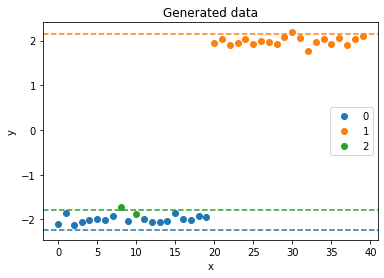

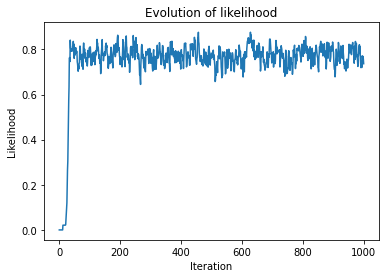

In [16]:
# Run algorithm 5
n = 40
N = 1000
alpha = 0.25

cs, phis, lhs = algorithm_5(N, data, alpha)
c = cs[-1]
phi = phis[-1]


plt.figure()
# define infinite list of colors
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, cluster in enumerate(np.unique(c)):
    plt.scatter(np.arange(n)[c == cluster], data[c == cluster], label=cluster, color=COLORS[i])
    plt.axhline(phi[cluster], color=COLORS[i], linestyle="--")
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# plot evolution of lh
plt.figure()
plt.plot(np.mean(lhs, axis=1))
plt.title("Evolution of likelihood")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.show()

# Algorithm 2

In our implementations, 
- $n$ is the number of observations $y = (y_1, ..., y_n)
- $c = (c_1, ..., c_n)$ is a list of integers, where $c_i$ is the cluster of observation $i$
- $\phi$ or $\theta$ depending of the algorithms is a list where $\phi_i$ is the mean of the cluster $c_i$ 

In [11]:
def algorithm_2_sampler(alpha, c_unique, c_count, c, n):

    # Gibbs Sampler following Eq 3.6
    new_parameter_prob = alpha / (n - 1 + alpha) * ri_integral(y[ii])
    old_parameter_prob = 1 / (n - 1 + alpha) * F_likelihood(phi[c[ii]], y[ii])
    # Sampling probabilities for all [old params , new param] and 
    sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
    # Normalize to get a probability distribution
    sampling_prob /= np.sum(sampling_prob)
    # Choose cluster with probability sampling_prob
    # The new cluster replaces an unused cluster
    ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
    return ci_star


In [24]:
def algorithm_2(n_iters, y, alpha):
    n = len(y)
    phis = np.zeros((n_iters+1, n), dtype=float)
    cs = np.zeros((n_iters+1, n), dtype=int)

    for iter in range(1, n_iters+1):
        phi = phis[iter-1].copy() 
        c = cs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)

            
            # Remove phi_ci from the state and draw a new value for ci from eq 3.6
            new_parameter_prob = alpha / (n - 1 + alpha) * ri_integral(y[ii])
            old_parameter_prob = 1 / (n - 1 + alpha) * F_likelihood(phi[c_unique], y[ii])
            # Sampling probabilities for all [old params , new param] 
            sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
            # Normalize to get a probability distribution
            sampling_prob /= np.sum(sampling_prob)
            # Choose cluster with probability sampling_prob
            # The new cluster replaces an unused cluster
            if np.sum(c == c[ii]) == 1:
                ci_star = np.random.choice(np.append(c_unique, c[ii]), p=sampling_prob)
            else:
                ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
            c[ii] = ci_star
            if np.sum(ci_star == c) == 1:
                phi[ci_star] = Hi_sampler(y[c == ci_star])
        
        for c_unique in np.unique(c):
            phi[c_unique] = np.mean(y[c == c_unique])
    
        cs[iter] = c.copy()
        phis[iter] = phi.copy()

    return cs, phis


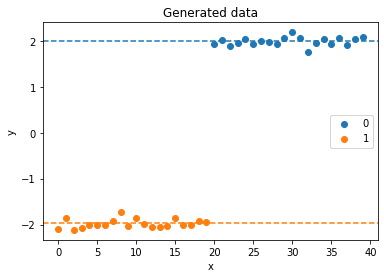

In [25]:
# Run algorithm 2
n = 40
N = 1000
alpha = 0.25

cs, phis = algorithm_2(N, data, alpha)
c = cs[-1]
phi = phis[-1]


plt.figure()
# define infinite list of colors
COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, cluster in enumerate(np.unique(c)):
    color = next(COLORS)
    plt.scatter(np.arange(n)[c == cluster], data[c == cluster], label=cluster, color=color)
    plt.axhline(phi[cluster], color=color, linestyle="--")
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
